In [1]:
%cd ../src
%load_ext autoreload
%autoreload 2

/home/ubuntu/SPVD_Lightning/src


In [2]:
from models.ddpm_unet_cattn import SPVUnet
import torch
import lightning as L
from models.g_spvd import GSPVD

In [26]:
from dataloaders.shapenet.shapenet_loader import ShapeNet

categories = ['car']
path = "../data/ShapeNet"

te = ShapeNet(path, "test", 2048, categories, load_renders=False)

Loading (test) pointclouds for car (02958343):   0%|          | 0/704 [00:00<?, ?it/s]

In [27]:
from utils.helper_functions import normalize_to_unit_sphere, standardize
from metrics.chamfer_dist import ChamferDistanceL2
from metrics.PyTorchEMD.emd import earth_mover_distance as EMD
from tqdm import tqdm

cd = ChamferDistanceL2()
# point_clouds = normalize_to_unit_sphere(torch.stack([te[i]['pc'] for i in range(len(te))])).cuda()
point_clouds = standardize(torch.stack([te[i]['pc'] for i in range(len(te))])).cuda()
P = torch.randn(2048, 3, requires_grad=True, device='cuda')


for lr in (0.05, 0.02, 0.01, 0.005):
    optim = torch.optim.Adam([P], lr=lr)
    p_bar = tqdm(range(50))
    for _ in p_bar:
        loss = sum(cd(P.unsqueeze(0), pc.unsqueeze(0)) for pc in point_clouds) / len(point_clouds)
        optim.zero_grad()
        loss.backward()
        optim.step()
        p_bar.set_postfix({'loss': loss.item()})

100%|██████████| 50/50 [00:09<00:00,  5.16it/s, loss=0.045]


In [28]:
from utils.visualization import display_pointclouds_grid
import numpy as np
# P = P
display_pointclouds_grid(np.array([P.detach().cpu(), point_clouds.cpu()[0]]), point_size=0.05)

Output()

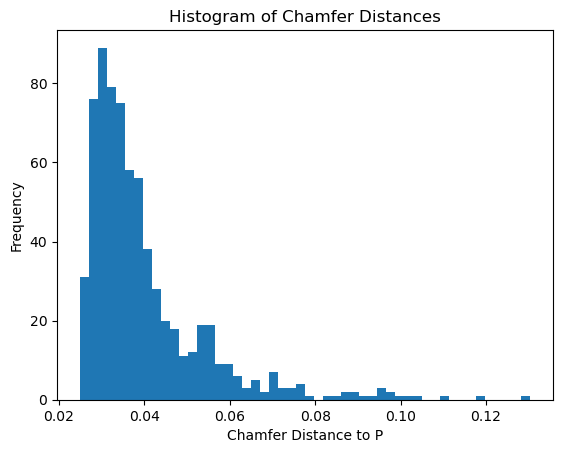

In [29]:
from scipy.stats import zscore
import numpy as np

import matplotlib.pyplot as plt

cd_values = [cd(P.unsqueeze(0), pc.unsqueeze(0)).item() for pc in point_clouds]
cd_values_np = np.array(cd_values)
z_scores = zscore(cd_values_np)
cd_values_filtered = cd_values_np[np.abs(z_scores) < 3]
cd_values = cd_values_filtered.tolist()

plt.hist(cd_values, bins=50)
plt.xlabel('Chamfer Distance to P')
plt.ylabel('Frequency')
plt.title('Histogram of Chamfer Distances')
plt.show()